In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from altair import Chart
plt.style.use('seaborn')

In [2]:
import caption_contest_data as ccd
responses = ccd.responses(577, path="../contests/responses")
responses.columns

Index(['alg_label', 'network_delay', 'participant_uid', 'response_time',
       'target', 'target_id', 'target_reward', 'timestamp_query_generated',
       'label', 'contest', 'filename'],
      dtype='object')

## Response time 
How long does the average user wait? That data is recorded in the responses and we can plot a histogram. 

We know that waiting for something to happen is characterized by an [exponential random variable]. Can we fit the PDF of an exponential random variable to the reponse time we see? 

[exponential random variable]:https://en.wikipedia.org/wiki/Exponential_distribution

In [3]:
most_responses = (responses['response_time'] >= 0) & (responses['response_time'] <= 15) 
df = responses[most_responses].copy()

/Users/scott/anaconda3/envs/ccd-api3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:62: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)


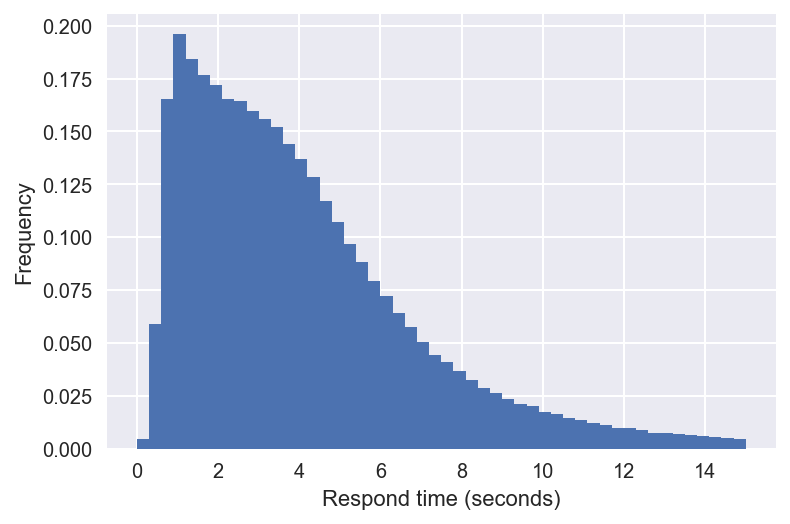

In [4]:
df['response_time'].plot.hist(bins=50, normed=True)
plt.xlabel('Respond time (seconds)')
plt.show()

In [5]:
users = df.participant_uid.unique()
num_users = len(users)
print(num_users, "total users")

9628 total users


## Concurrent users
How many users hit our system in a one second period?

In [6]:
import datetime
df = responses.copy()
contest_start = df['timestamp_query_generated'].min()
contest_end = df['timestamp_query_generated'].max()
df = df.sort_values(by='timestamp_query_generated')
delta = datetime.timedelta(seconds=1)
df['seconds_elapsed'] = df['timestamp_query_generated'] - contest_start
df['seconds_elapsed'] = df.apply(lambda row: row['seconds_elapsed'].total_seconds(), axis=1)

In [7]:
total_seconds = (contest_end - contest_start).total_seconds()

In [9]:
def find_users_in_range(start, end):
    if start % 1000 == 0:
        print(start)
    n_questions = (times >= start) & (times < end)
    return {'questions served': n_questions.sum(), 'start': start, 'end': end}

from joblib import Parallel, delayed

times = df['seconds_elapsed'].values
print(f"Launching {total_seconds/1000}k jobs...")
stats = Parallel(n_jobs=-1)(delayed(find_users_in_range)(offset, offset + 60)
                   for offset in range(int(total_seconds)))
print(stats[:3])

Launching 611.334811853k jobs...
[{'questions served': 1, 'start': 0, 'end': 60}, {'questions served': 0, 'start': 1, 'end': 61}, {'questions served': 0, 'start': 2, 'end': 62}]


In [10]:
stats = pd.DataFrame(stats)

In [12]:
stats.head()

,questions served,start,end
0,1,0,60
1,0,1,61
2,0,2,62
3,0,3,63
4,0,4,64


In [11]:
max_questions_per_minute = stats['questions served'].max()
print(f'Questions served per minute: {max_questions_per_minute}')

Questions served per minute: 1060


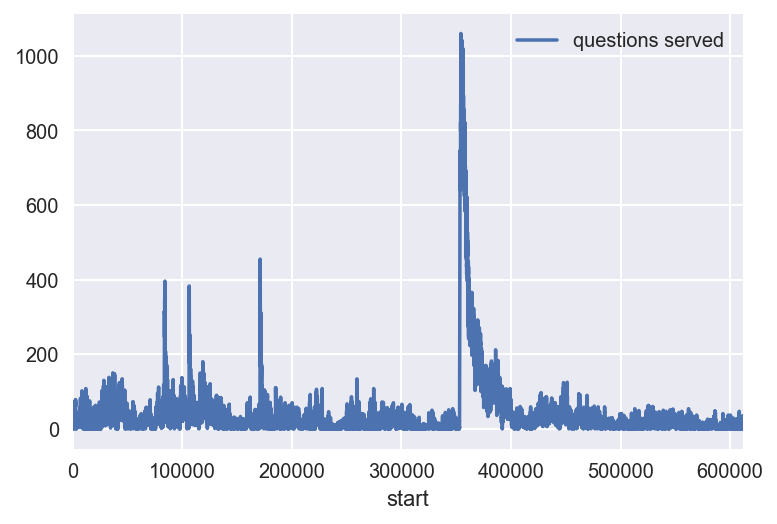

In [14]:
stats.plot(x="start", y="questions served")

## Network delay
How long does our system take to respond?

In [15]:
most_delays = (responses['network_delay'] >= 0) & (responses['network_delay'] <= 2)
df = responses[most_delays]

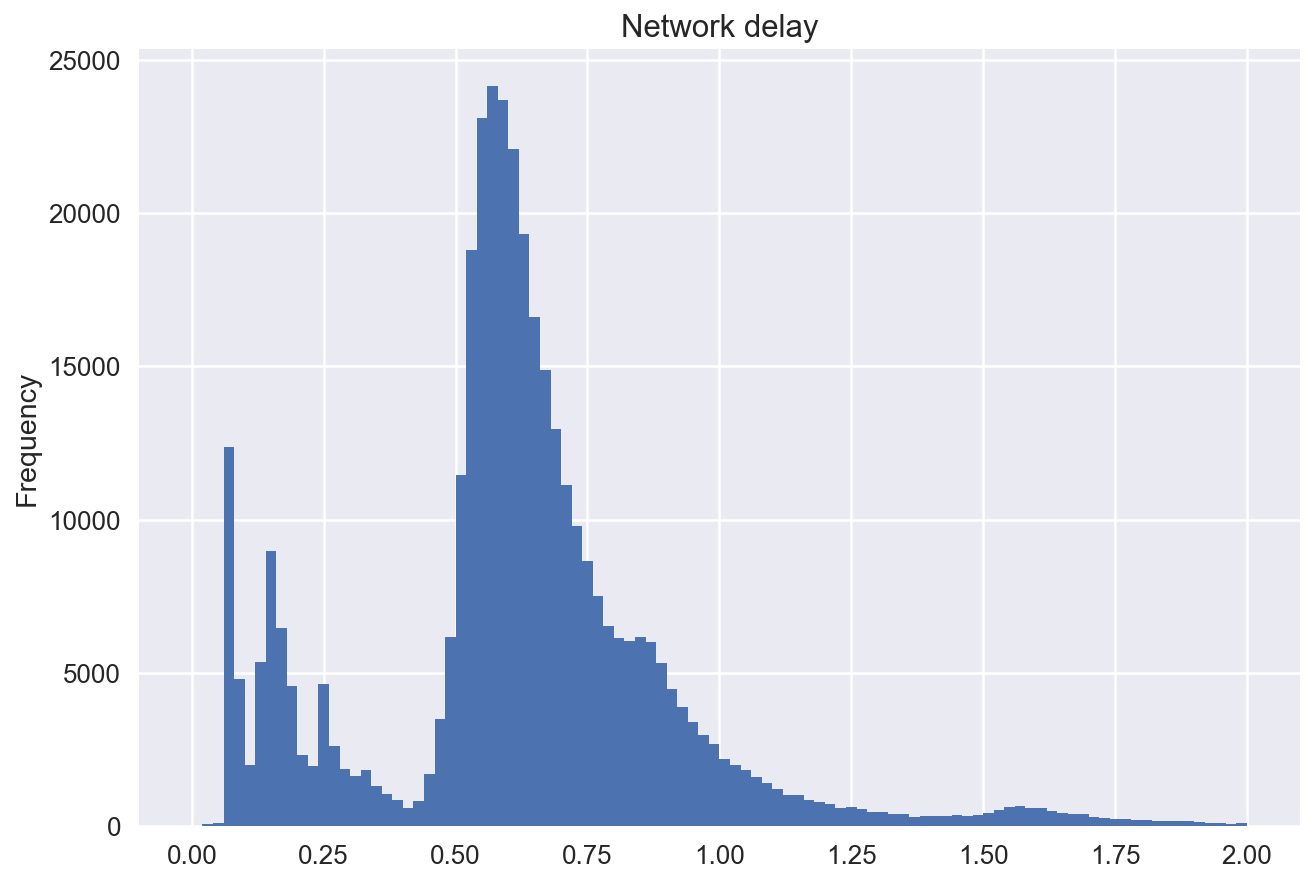

In [16]:
plt.style.use('seaborn-talk')
df['network_delay'].plot.hist(bins=100)
plt.title('Network delay')
plt.show()